In [11]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner

In [12]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N])
    return state


def Gompertz(a,b,c,l=150,o=0):
    t = tt.arange(l)+tt.cast(o,dtype="float64")
    return a*tt.exp(-b*tt.exp(-c*t))

b,g,n,i0 = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
z = tt.constant(0.,dtype='float64')
S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(b,g,n,n,i0,z,i)
sir_f = theano.function(inputs=[b,g,n,i0,i],outputs=[S_t,I_t,R_t,dS])

a,b,c,offset = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
est = Gompertz(a,b,c,l=i,o=offset)
gomp_f = theano.function(inputs=[a,b,c,i,offset],outputs=[est])

def Rsquare(data,est):
    md = np.mean(data)
    ss_tot = np.sum(np.power(data-md,2))
    ss_res = np.sum(np.power(data-est,2))
    return 1-ss_res/ss_tot


In [13]:
with open("estimates/sir_symptomatic_1598942335","rb") as f:
    sir_est = pickle.load(f)
    
with open("estimates/gomp_symptomatic_1598946460","rb") as f:
    gomp_est = pickle.load(f)

In [16]:
# Transpose the Dataset for the SIR-Fit

t0 = time.time()
estimation_series = {}
for k,v in sir_est.items():
    print(k)
    for p in ['beta','gamma','N','I0']:
        if p not in estimation_series.keys():
            estimation_series[p] = {"mu":[],2.5:[],16:[],50:[],84:[],97.5:[]} 
        es = estimation_series[p]
        es["mu"].append(np.mean(v[p]))
        q = np.percentile(v[p],q=(2.5,16,50,84,97.5))
        es[2.5].append(q[0])
        es[16].append(q[1])
        es[50].append(q[2])
        es[84].append(q[3])
        es[97.5].append(q[4])
    
    sat,Rsq,Repro= [],[],[]
    for i,beta,gamma,N,I0 in zip(range(len(v["beta"])),v["beta"],v["gamma"],v["N"],v["I0"]):
        S_t,I_t,R_t,dS = sir_f(beta,gamma,N,I0,300)
        est = -np.cumsum(dS,axis=0)
        sat.append( est[-1] )
        Repro.append(beta/gamma)
        
        Rsq.append(Rsquare(data[:k],est[:k]))
#    estimation_series["SdS"].append(np.array(sest))
    
    sir_est
    
    for k2,v2 in zip(["saturation","Rsq","Repro0"],[sat,Rsq,Repro]):
        if k2 not in estimation_series.keys():
            estimation_series[k2] = {"mu":[],2.5:[],16:[],50:[],84:[],97.5:[]} 
        es = estimation_series[k2]
        sata = np.array(v2)
        q = np.percentile(sata,q=(2.5,16,50,84,97.5))
        es["mu"].append(np.mean(sata))
        es[2.5].append(q[0])
        es[16].append(q[1])
        es[50].append(q[2])
        es[84].append(q[3])
        es[97.5].append(q[4])
        
    max_rsq,max_rsq_i,max_set = 0,0,{}
    for i,rsq in enumerate(Rsq):
        if rsq > max_rsq:
            max_rsq = rsq
            max_rsq_i = i
    if "best_index" not in estimation_series.keys():
        estimation_series["best_index"] = []
    estimation_series["best_index"].append(max_rsq_i)
    
#    print(k,v["ssd"],np.mean(v["N"]),np.mean(sata))
t1 = time.time()
print("Recalculate SIR for saturation in %.2fs"%(t1-t0))
sir_est_series = estimation_series

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
Recalculate SIR for saturation in 226.01s


[0.2774110127429231, 0.2800243308825544, 0.2752297183669717, 0.2777300895434441, 0.2745970350186664, 0.27805134809525306, 0.27103277737407205, 0.28242587464701835, 0.27457242567641404, 0.27332666694420854, 0.2883572585666495, 0.2829948882301271, 0.30820275141297193, 0.2751939370218789, 0.2912666271256178, 0.27942753328077735, 0.27318876323954355, 0.28445078999495166, 0.2893362690373434, 0.2772496030199434, 0.2938250276488254, 0.30987167757600725, 0.2937961381394839, 0.28865412742523977, 0.282322829127865, 0.30303373972415, 0.2823229782561229, 0.2826345811801445, 0.28153925952744296, 0.2782290779908146, 0.31187988541787576]


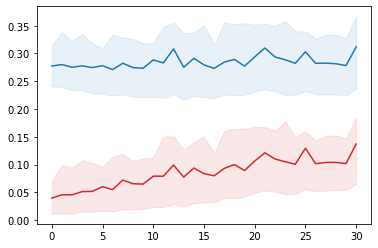

In [17]:
print(sir_est_series["beta"][50])
l = len(sir_est_series["beta"][50])
r = range(l)
gamma = sir_est_series["gamma"]
plt.plot(r,gamma[50],color="tab:red")
plt.fill_between(r,gamma[2.5],gamma[97.5],alpha=.1,color="tab:red")

beta = sir_est_series["beta"]
plt.plot(r,beta[50],color="tab:blue")
plt.fill_between(r,beta[2.5],beta[97.5],alpha=.1,color="tab:blue")

In [18]:
# Transpose the Dataset for the Gompertz-Fit

estimation_series = {}
for k,v in gomp_est.items():
    print(k)
    for p in ['a','b','c']:
        if p not in estimation_series.keys():
            estimation_series[p] = {"mu":[],2.5:[],16:[],50:[],84:[],97.5:[]} 
        es = estimation_series[p]
        es["mu"].append(np.mean(v[p]))
        q = np.percentile(v[p],q=(2.5,16,50,84,97.5))
        es[2.5].append(q[0])
        es[16].append(q[1])
        es[50].append(q[2])
        es[84].append(q[3])
        es[97.5].append(q[4])
        
    Rsq= []
    for i,a,b,c in zip(range(len(v["a"])),v["a"],v["b"],v["c"]):
        est = gomp_f(a,b,c,300,0)[0]
        
        Rsq.append(Rsquare(data[:k],est[:k]))
#    estimation_series["SdS"].append(np.array(sest))
    
    max_rsq,max_rsq_i = 0,0
    for i,rsq in enumerate(Rsq):
        if rsq > max_rsq:
            max_rsq = rsq
            max_rsq_i = i
    if "best_index" not in estimation_series.keys():
        estimation_series["best_index"] = []
    estimation_series["best_index"].append(max_rsq_i)
    
    for k2,v2 in zip(["Rsq"],[Rsq]):
        if k2 not in estimation_series.keys():
            estimation_series[k2] = {"mu":[],2.5:[],16:[],50:[],84:[],97.5:[]} 
        es = estimation_series[k2]
        sata = np.array(v2)
        q = np.percentile(sata,q=(2.5,16,50,84,97.5))
        es["mu"].append(np.mean(sata))
        es[2.5].append(q[0])
        es[16].append(q[1])
        es[50].append(q[2])
        es[84].append(q[3])
        es[97.5].append(q[4])        
        
#    print(k,v["ssd"],np.mean(v["a"]))

gomp_est_series = estimation_series

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


[194319.7002788214, 182263.58701392278, 172912.98537195608, 166141.00726006558, 162344.40527930774, 156772.58359707345, 153089.78437230273, 149183.51501459334, 147151.34228813526, 144680.72585629259, 142809.01795176847, 141218.7213181282, 139687.70906162006, 138267.4861149796, 137598.87382256024, 136069.64158237787, 135401.26687566523, 134398.9224215088, 133983.9995793138, 133457.56498467363, 132988.26636874865, 132370.53209808437, 131718.05302150676, 131680.9126977513, 130801.25518971184, 130789.21272074853, 130740.66230409045, 130384.2987279717, 130147.35259502789, 130137.22758634033, 129992.74229084511]


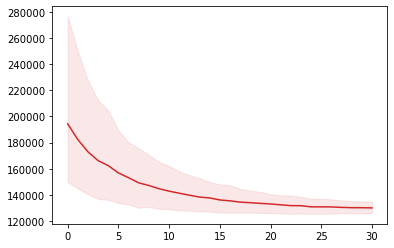

In [19]:
print(gomp_est_series["a"][50])
l = len(gomp_est_series["a"][50])
r = range(l)
a = gomp_est_series["a"]
plt.plot(r,a[50],color="tab:red")
plt.fill_between(r,a[2.5],a[97.5],alpha=.1,color="tab:red")

#beta = gomp_est_series["beta"]
#plt.plot(r,beta[50],color="tab:blue")
#plt.fill_between(r,beta[2.5],beta[97.5],alpha=.1,color="tab:blue")

In [20]:
#print(sir_est)
#sir_est_series["best_index"]
print(sir_est.keys())

def FindBestSIR(estimates,series):
    best = {}
    t = sorted(estimates.keys())
    p = ["beta","gamma","N","I0"]
    for k in p:
        best[k] = np.array([estimates[j][k][i] for j,i in zip(t,series["best_index"])])
    
    
    sat,Rsq,Repro= [],[],[]
    for beta,gamma,N,I0,k in zip(best["beta"],best["gamma"],best["N"],best["I0"],t):
        S_t,I_t,R_t,dS = sir_f(beta,gamma,N,I0,300)
        est = -np.cumsum(dS,axis=0)
        sat.append( est[-1] )
        Repro.append(beta/gamma)
        Rsq.append(Rsquare(data[:k],est[:k]))
        
    best["saturation"] = np.array(sat)
    best["Rsq"] = np.array(Rsq)
    best["Repro0"] = np.array(Repro)
    return best

def FindBestGompertz(estimates,series):
    best = {}
    t = sorted(estimates.keys())
    p = ["a","b","c"]
    for k in p:
        best[k] = np.array([estimates[j][k][i] for j,i in zip(t,series["best_index"])])
    
    Rsq = []
    for a,b,c,k in zip(best["a"],best["b"],best["c"],t):
        est = gomp_f(a,b,c,300,0)[0]
        Rsq.append(Rsquare(data[:k],est[:k]))
    best["Rsq"] = np.array(Rsq)
    return best

best_sir = FindBestSIR(sir_est,sir_est_series)
best_gomp = FindBestGompertz(gomp_est,gomp_est_series)

print(best_sir)
print(best_gomp)

dict_keys([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])
{'beta': array([0.29830284, 0.32573747, 0.32506815, 0.31310003, 0.31387581,
       0.2966725 , 0.29237494, 0.32363275, 0.26832655, 0.30881077,
       0.26458439, 0.29244085, 0.29269202, 0.30103417, 0.32831743,
       0.29985612, 0.28535454, 0.27497039, 0.27522557, 0.24972093,
       0.28987405, 0.28538559, 0.28473426, 0.27637399, 0.26664093,
       0.27528548, 0.24973212, 0.26958989, 0.25673863, 0.22896044,
       0.25054517]), 'gamma': array([0.0676849 , 0.09292704, 0.10089587, 0.09874096, 0.09743816,
       0.08872113, 0.09235028, 0.11809448, 0.07650233, 0.11081223,
       0.07432074, 0.10758024, 0.10782669, 0.11918626, 0.15003719,
       0.11937153, 0.10680794, 0.10563926, 0.10420019, 0.08097751,
       0.12139179, 0.11769992, 0.12007302, 0.11446948, 0.10850984,
       0.11264584, 0.08966545, 0.10899051, 0.10516588, 0.0751688 ,
       0.09502669]), 

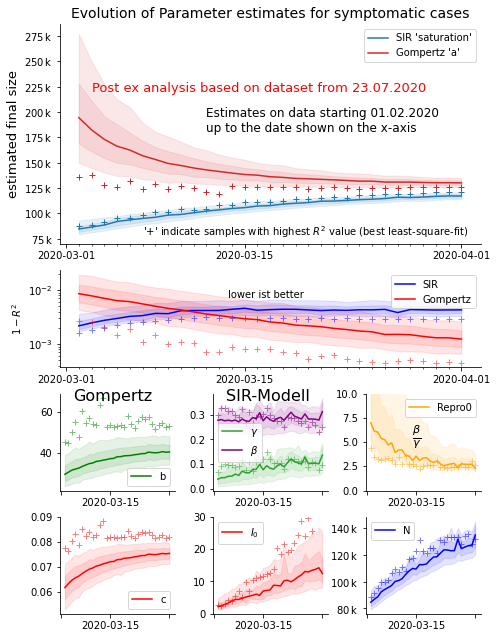

In [21]:
fig = plt.figure(figsize=(7,9))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.125,right=0.96,top=0.95,bottom=0.04)

ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=31,freq='D')

gs = fig.add_gridspec(5, 3)
ax = fig.add_subplot(gs[0:2,0:3])

b_alpha = .5

for e,b,pn,k,c in zip([sir_est_series,gomp_est_series],[best_sir,best_gomp],["saturation","a"],["SIR","Gompertz"],["tab:blue","tab:red"]):
    ax.plot(pts,e[pn][50],color=c,label="%s '%s'"%(k,pn))
    ax.fill_between(pts,e[pn][16],e[pn][84],alpha=.1,color=c)
    ax.fill_between(pts,e[pn][2.5],e[pn][97.5],alpha=.1,color=c)

    ax.plot(pts,b[pn],"+",color=c)

ax.set_ylabel("estimated final size",fontsize=13)
ax.legend()

rx = fig.add_subplot(gs[2:3,0:3])
for d,b,k,c in zip([sir_est_series,gomp_est_series],[best_sir,best_gomp],["SIR","Gompertz"],["blue","red"]):
    e = d["Rsq"]
    rx.semilogy(pts,1-np.array(e[50]),color=c,label="%s"%(k))
    rx.fill_between(pts,1-np.array(e[84]),1-np.array(e[16]),color=c,alpha=.1)
    rx.fill_between(pts,1-np.array(e[2.5]),1-np.array(e[97.5]),color=c,alpha=.1)
    rx.semilogy(pts,1-b["Rsq"],"+",color=c,alpha=b_alpha)
    
rx.legend()
rx.text(0.4,.72,"lower ist better",transform=rx.transAxes)
rx.set_ylabel(r"$1-R^2$")

bx = fig.add_subplot(gs[3,1])
for k,c in zip(["gamma","beta"],["tab:green","purple"]):
    bx.plot(pts,sir_est_series[k][50],label=r"$\%s$"%k,color=c)
    bx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    bx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    bx.plot(pts,best_sir[k],"+",color=c,alpha=b_alpha)
bx.legend()

gx = fig.add_subplot(gs[3,2])
for k,c in zip(["Repro0"],["orange"]):
    gx.plot(pts,sir_est_series[k][50],label=k,color=c)
    gx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    gx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    gx.plot(pts,best_sir["Repro0"],"+",color=c,alpha=b_alpha)

gx.legend()
gx.set_ylim([0,10])
gx.text(.4,.5,r"$\frac{\beta}{\gamma}$",transform=gx.transAxes,fontsize=16)

cx = fig.add_subplot(gs[4,2])
for k,c in zip(["N"],["blue"]):
    cx.plot(pts,sir_est_series[k][50],label=k,color=c)
    cx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    cx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    cx.plot(pts,best_sir["N"],"+",color=c,alpha=b_alpha)

cx.legend()

dx = fig.add_subplot(gs[4,1])
for k,c in zip(["I0"],["red"]):
    dx.plot(pts,sir_est_series[k][50],label=r"$I_0$",color=c)
    dx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    dx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    dx.plot(pts,best_sir["I0"],"+",color=c,alpha=b_alpha)

dx.legend(loc="upper left")
dx.set_ylim([0,30])


ex = fig.add_subplot(gs[3,0])
fx = fig.add_subplot(gs[4,0])

for tx,k,c in zip([ex,fx],["b","c"],["green","red"]):
    tx.plot(pts,gomp_est_series[k][50],label=k,color=c)
    tx.fill_between(pts,gomp_est_series[k][16],gomp_est_series[k][84],alpha=.1,color=c)
    tx.fill_between(pts,gomp_est_series[k][2.5],gomp_est_series[k][97.5],alpha=.1,color=c)
    tx.plot(pts,best_gomp[k],"+",color=c,alpha=b_alpha)

    tx.legend(loc="lower right")

ex.text(.12,.92,"Gompertz",transform=ex.transAxes,fontsize=16)
bx.text(.12,.92,"SIR-Modell",transform=bx.transAxes,fontsize=16)
    
for tx in [ax,bx,cx,dx,ex,fx,rx,gx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
    tx.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
    tx.set_xticklabels(["",datetime.date(2020,3,15),""])

#    tx.set_xlim([ts[15],ts[l+1]])

    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)

ax.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
rx.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
ax.set_xticklabels([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
rx.set_xticklabels([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])

ax.set_xticks(pts,minor=True)
rx.set_xticks(pts,minor=True)
    
ax.set_title("Evolution of Parameter estimates for symptomatic cases",fontsize=14)
ax.text(pts[1],220000,"Post ex analysis based on dataset from 23.07.2020",fontsize=13,color="red")
ax.text(pts[10],180000,"Estimates on data starting 01.02.2020\nup to the date shown on the x-axis",fontsize=12)
#ax.text(pts[5],-20000,"SIR\nParameter-estimates\nright column",fontsize=10)
#ax.text(pts[0],-80000,"Gompertz\nParameter-estimates\nleft column",fontsize=10)
ax.text(pts[5],78000,r"'+' indicate samples with highest $R^2$ value (best least-square-fit)",fontsize=10)


fig.savefig("SIR-Gomp-Comp.png",dpi=300)

In [ ]:
fig = plt.figure(figsize=(7,9))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.125,right=0.96,top=0.95,bottom=0.04)

ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=31,freq='D')

gs = fig.add_gridspec(5, 3)
ax = fig.add_subplot(gs[0:2,0:3])

b_alpha = .5

for e,b,pn,k,c in zip([sir_est_series,gomp_est_series],[best_sir,best_gomp],["saturation","a"],["SIR","Gompertz"],["tab:blue","tab:red"]):
 #   ax.plot(pts,e[pn][50],color=c,label="%s '%s'"%(k,pn))
  #  ax.fill_between(pts,e[pn][16],e[pn][84],alpha=.1,color=c)
  #  ax.fill_between(pts,e[pn][2.5],e[pn][97.5],alpha=.1,color=c)

    ax.plot(pts,b[pn],color=c,label="%s '%s'"%(k,pn))

ax.set_ylabel("estimated final size",fontsize=13)
ax.legend()

rx = fig.add_subplot(gs[2:3,0:3])
for d,b,k,c in zip([sir_est_series,gomp_est_series],[best_sir,best_gomp],["SIR","Gompertz"],["blue","red"]):
    e = d["Rsq"]
#    rx.semilogy(pts,1-np.array(e[50]),color=c,label="%s"%(k))
 #   rx.fill_between(pts,1-np.array(e[84]),1-np.array(e[16]),color=c,alpha=.1)
  #  rx.fill_between(pts,1-np.array(e[2.5]),1-np.array(e[97.5]),color=c,alpha=.1)
    rx.semilogy(pts,1-b["Rsq"],color=c,alpha=b_alpha,label="%s"%(k))
    
rx.legend()
rx.text(0.4,.72,"lower ist better",transform=rx.transAxes)
rx.set_ylabel(r"$1-R^2$")

bx = fig.add_subplot(gs[3,1])
for k,c in zip(["gamma","beta"],["tab:green","purple"]):
 #   bx.plot(pts,sir_est_series[k][50],label=r"$\%s$"%k,color=c)
 #   bx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
#    bx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    bx.plot(pts,best_sir[k],color=c,alpha=b_alpha)
bx.legend()

gx = fig.add_subplot(gs[3,2])
for k,c in zip(["Repro0"],["orange"]):
    gx.plot(pts,sir_est_series[k][50],label=k,color=c)
    gx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    gx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    gx.plot(pts,best_sir["Repro0"],"+",color=c,alpha=b_alpha)

gx.legend()
gx.set_ylim([0,10])
gx.text(.4,.5,r"$\frac{\beta}{\gamma}$",transform=gx.transAxes,fontsize=16)

cx = fig.add_subplot(gs[4,2])
for k,c in zip(["N"],["blue"]):
    cx.plot(pts,sir_est_series[k][50],label=k,color=c)
    cx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    cx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    cx.plot(pts,best_sir["N"],"+",color=c,alpha=b_alpha)

cx.legend()

dx = fig.add_subplot(gs[4,1])
for k,c in zip(["I0"],["red"]):
    dx.plot(pts,sir_est_series[k][50],label=r"$I_0$",color=c)
    dx.fill_between(pts,sir_est_series[k][16],sir_est_series[k][84],alpha=.1,color=c)
    dx.fill_between(pts,sir_est_series[k][2.5],sir_est_series[k][97.5],alpha=.1,color=c)
    dx.plot(pts,best_sir["I0"],"+",color=c,alpha=b_alpha)

dx.legend(loc="upper left")
dx.set_ylim([0,30])


ex = fig.add_subplot(gs[3,0])
fx = fig.add_subplot(gs[4,0])

for tx,k,c in zip([ex,fx],["b","c"],["green","red"]):
    tx.plot(pts,gomp_est_series[k][50],label=k,color=c)
    tx.fill_between(pts,gomp_est_series[k][16],gomp_est_series[k][84],alpha=.1,color=c)
    tx.fill_between(pts,gomp_est_series[k][2.5],gomp_est_series[k][97.5],alpha=.1,color=c)
    tx.plot(pts,best_gomp[k],"+",color=c,alpha=b_alpha)

    tx.legend(loc="lower right")

ex.text(.12,.92,"Gompertz",transform=ex.transAxes,fontsize=16)
bx.text(.12,.92,"SIR-Modell",transform=bx.transAxes,fontsize=16)
    
for tx in [ax,bx,cx,dx,ex,fx,rx,gx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
    tx.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
    tx.set_xticklabels(["",datetime.date(2020,3,15),""])

#    tx.set_xlim([ts[15],ts[l+1]])

    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)

ax.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
rx.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
ax.set_xticklabels([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
rx.set_xticklabels([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])

ax.set_xticks(pts,minor=True)
rx.set_xticks(pts,minor=True)
    
ax.set_title("Evolution of Parameter estimates for symptomatic cases",fontsize=14)
ax.text(pts[1],220000,"Post ex analysis based on dataset from 23.07.2020",fontsize=13,color="red")
ax.text(pts[10],180000,"Estimates on data starting 01.02.2020\nup to the date shown on the x-axis",fontsize=12)
#ax.text(pts[5],-20000,"SIR\nParameter-estimates\nright column",fontsize=10)
#ax.text(pts[0],-80000,"Gompertz\nParameter-estimates\nleft column",fontsize=10)
#ax.text(pts[5],78000,r"'+' indicate samples with highest $R^2$ value (best least-square-fit)",fontsize=10)


fig.savefig("SIR-Gomp-Comp_minimal.png",dpi=300)

In [15]:
# Data from
#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Germany,51.165690999999995,10.451526,
jhu_deaths = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,7,9,11,17,24,28,44,67,84,94,123,157,206,267,342,433,533,645,775,920,1107,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052,4352,4459,4586,4862,5033,5279,5575,5760,5877,5976,6126,6314,6467,6623,6736,6812,6866,6993,6993,7275,7392,7510,7549,7569,7661,7738,7861,7884,7897,7938,7962,8003,8081,8144,8203,8228,8261,8283,8309,8372,8428,8470,8504,8530,8540,8555,8563,8602,8635,8658,8673,8685,8695,8736,8752,8772,8783,8793,8801,8807,8820,8851,8875,8887,8895,8895,8899,8914,8928,8940,8965,8968,8968,8976,8990,8995,9006,9010,9020,9023,9022,9032,9046,9057,9063,9070,9071,9074,9078,9080,9087,9088,9091,9092,9094,9099,9102,9110,9120,9124,9124,9125,9131,9135,9144,9147,9154,9154,9154,9163,9179,9181,9195,9201,9202,9203,9208,9213,9217,9230,9235,9235,9236,9241,9249,9263,9266,9272,9275,9276,9281,9285,9290,9290,9299]
jhu_ts = pd.date_range(datetime.date(2020,1,21),periods=len(jhu_deaths),freq='D')

# Limit to non-zero values, dropping the front of the list
first_non_zero_index = 47
jhu_deaths1 = jhu_deaths[first_non_zero_index:]
jhu_ts1 = jhu_ts[first_non_zero_index:]
print("first non zero deaths timestamp",jhu_ts1[0])

# Alternative Deaths from Situation-report graph of actual dates of deaths
rki_deaths_per_day = [1, 1, 1, 1, 5, 2, 3, 4, 11, 13, 12, 21, 40, 24, 42, 42, 67, 76, 92, 104, 107, 114, 172, 165, 162, 204, 199, 223, 240, 240, 254, 260, 257, 240, 246, 239, 243, 245, 227, 239, 241, 191, 203, 209, 172, 194, 157, 163, 129, 141, 132, 125, 128, 121, 106, 76, 92, 78, 93, 82, 69, 54, 63, 64, 63, 42, 54, 66, 47, 29, 40, 44, 45, 47, 31, 33, 27, 30, 31, 23, 21, 18, 19, 17, 18, 24, 15, 18, 18, 14, 8, 9, 8, 6, 11, 11, 14, 9, 6, 9, 7, 7, 9, 6, 3, 4, 4, 6, 7, 7, 7, 4, 7, 8, 1]
rki_deaths = np.cumsum(rki_deaths_per_day)
rki_ts = pd.date_range(datetime.date(2020,3,8),periods=len(rki_deaths),freq='D')

sources = {"jhu_deaths":(jhu_deaths,jhu_ts),"jhu1_deaths":(jhu_deaths1,jhu_ts1),"rki_deaths":(rki_deaths,rki_ts)}
# Include Symptomatic from arcgis-Dump
rki_df = pd.read_csv("data/RKI_COVID19_200723.csv", sep=",") 

def rdate(s):
    r = None
    if "T" in s:
        r = datetime.datetime.strptime(s.split("T")[0],"%Y-%m-%d")
    if "-" in s:
        r = datetime.datetime.strptime(s.split(" ")[0],"%Y-%m-%d")
    else:
        if s[:4] == "2020":
            r = datetime.datetime.strptime(s.split(" ")[0],"%Y/%m/%d")
        else:
            r = datetime.datetime.strptime(s.split(" ")[0],"%m/%d/%Y")
    return r.date()

cols = [x for x in ["Meldedatum","Refdatum"] if x in rki_df.columns]
for col in cols:
    if col in rki_df:
        rki_df[col] = rki_df[col].apply(rdate)
        
rki_df = rki_df.filter(items=["Meldedatum","Refdatum","NeuerFall","AnzahlFall","IstErkrankungsbeginn","AnzahlTodesfall"])

ts = pd.date_range(datetime.date(2020,1,1),periods=200,freq='D')
symptomatic_timeseries = pd.date_range(datetime.date(2020,2,1),periods=150,freq='D')

symptomatic = np.zeros(len(ts))
for i,t in enumerate(ts):
    m = rki_df[rki_df["Refdatum"] == t]
    symptomatic[i] = np.sum(m[m["IstErkrankungsbeginn"] == 1]["AnzahlFall"])

cs = np.cumsum(symptomatic)
s = cs[(symptomatic_timeseries[0]-ts[0]).days:]
s = s[:len(ts)]

sources["rki_symptomatic"] = (s,symptomatic_timeseries)
data,ts = sources["rki_symptomatic"]

print("["+",".join(["%d"%x for x in data[:120]])+"]")

first non zero deaths timestamp 2020-03-08 00:00:00
[20,25,27,29,31,32,34,34,36,42,43,47,52,58,67,72,81,91,101,128,144,167,211,276,380,533,693,901,1089,1304,1587,1862,2238,2647,3281,4081,5166,6853,8988,11652,14603,18190,21832,25590,30574,34803,39122,42877,47260,50792,53719,57907,61020,64465,67524,70704,73673,76015,79406,81946,84948,87625,90354,92499,94398,96843,98953,100943,102826,104426,105772,107084,108350,109646,110931,112072,113149,114081,114878,115912,116725,117526,118305,119012,119626,120141,120840,121399,121900,122489,122959,123373,123798,124331,124793,125200,125600,125978,126302,126598,126964,127288,127588,127832,128190,128486,128683,129036,129250,129574,129766,129978,130167,130343,130607,130836,131091,131293,131482,131638]


In [ ]:
print(ts[51])
print(ts[30])
print(pts[21])
sum(data*data)

In [22]:
Dataset = {"Erster Datenpunkt":pd.DatetimeIndex([ts[0]]*len(pts)),"Letzter Datenpunkt":pts}
Dataset.update({"SIR_beta":best_sir["beta"],"SIR_gamma":best_sir["gamma"],"SIR_I0":best_sir["I0"],"SIR_N":best_sir["N"],"SIR_final":best_sir["saturation"],"SIR_R^2":best_sir["Rsq"]})
Dataset.update({"Gompertz_a":best_gomp["a"],"Gompertz_b":best_gomp["b"],"Gompertz_c":best_gomp["c"],"Gompertz_R^2":best_gomp["Rsq"]})
dset = pd.DataFrame.from_dict(Dataset)

dset.to_csv("estimates/Estimates_on_Symptomatic_starting_2020-02-01.csv")

In [ ]:



if True:
    fig = plt.figure(figsize=(7,8))
    fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.125,right=0.93,top=0.92,bottom=0.05)
    
    ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
    pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=120,freq='D')
    print(pts[0])
    gs = fig.add_gridspec(1, 1)
    
    ax = fig.add_subplot(gs[0,0])
    
    hom = {"1.Versuch":[227646,9.92,.014,0],"2.Versuch":[106397,7.061,.107,0],"2.Ver.Offset":[106397,7.061,.107,-28]}
    for k,h in hom.items():
        h.append(gomp_f(h[0],h[1],h[2],len(ts),h[3])[0])
    
    print(sir_est_series["beta"].keys())
    
    n = 22
    nx = n+30
    print(ts[30])
    
    
    sest = sir_est_series
    gest = gomp_est_series
    
    print(sir_est.keys())
    v = sir_est[sorted(sir_est.keys())[n]]
    cs = []
    for i,beta,gamma,N,I0 in zip(range(len(v["beta"])),v["beta"],v["gamma"],v["N"],v["I0"]):
        S_t,I_t,R_t,dS = sir_f(beta,gamma,N,I0,nx)
        cs.append(-np.cumsum(dS))
    cs = np.array(cs)
    qcs = np.percentile(cs,q=(2.5,16,84,97.5),axis=0)
    
    print(gomp_est.keys())
    v = gomp_est[sorted(gomp_est.keys())[n]]
    cs = []
    for i,at,bt,ct in zip(range(len(v["a"])),v["a"],v["b"],v["c"]):
        g = gomp_f(at,bt,ct,nx,0)
        cs.append(g[0])
    cs = np.array(cs)
    print(cs.shape)
    gcs = np.percentile(cs,q=(2.5,16,84,97.5),axis=0)
    
    print(cs.shape)
    
    
    print(sest["beta"][50][n],sest["gamma"][50][n],sest["N"][50][n],sest["I0"][50][n])
    print(gest["a"][50][n],gest["b"][50][n],gest["c"][50][n])
    
    S_t,I_t,R_t,dS = sir_f(sest["beta"][50][n],sest["gamma"][50][n],sest["N"][50][n],sest["I0"][50][n],300)
    est_sir = -np.cumsum(dS)
    
    print(est_sir[-1])
    est_gomp = gomp_f(gest["a"][50][n],gest["b"][50][n],gest["c"][50][n],len(ts),0)[0]
    

    #ax.plot(sts,y,label="simple")
    ax.plot(ts[:nx],data[:nx],"+",label="data",color="black",alpha=1)
    
    hcolors = ["purple","green","orange"]
    i = 0
    for k,v in hom.items():
        a,b,c,o,d = v
    #    ax.plot(ts[:nx],d[:nx],label=r"Homburg's Gompertz (%s) $a=%.1f$k $b=%.2f$ $c=%.4f$"%(k,a/1000.,b,c),color=hcolors[i])
        i+=1
    
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    ax.plot(ts[:nx],est_sir[:nx],label=r"SIR estimate $\beta=%.3f$ $\gamma=%.3f$ $N=%.1f$k $I_0=%.1f$ final$=%.1fk$"%(sest["beta"][50][n],sest["gamma"][50][n],sest["N"][50][n]/1000,sest["I0"][50][n],est_sir[-1]/1000.),color="tab:blue")
    ax.fill_between(ts[:nx],qcs[0],qcs[-1],color="tab:blue",alpha=.1)
    ax.fill_between(ts[:nx],qcs[1],qcs[-2],color="tab:blue",alpha=.1)
    
    ax.plot(ts[:nx],est_gomp[:nx],label=r"Gompertz $a=%.1f$k $b=%.2f$ $c=%.4f$"%(gest["a"][50][n]/1000.,gest["b"][50][n],gest["c"][50][n]),color="tab:red")
    ax.fill_between(ts[:nx],gcs[0],gcs[-1],color="tab:red",alpha=.1)
    ax.fill_between(ts[:nx],gcs[1],gcs[-2],color="tab:red",alpha=.1)
    ax.legend(loc="upper left")
    
    ax.set_ylabel("symptomatic cases",fontsize=16)
    ax.set_title("Symptomatic cases up to %s\nFrom Dataset 2020-07-23"%ts[nx].date(),fontsize=16)
        
    rsqsir = Rsquare(data[:nx],est_sir[:nx])
    rsqgomp = Rsquare(data[:nx],est_gomp[:nx])
    rsqhomOffset = Rsquare(data[:nx],hom["2.Ver.Offset"][-1][:nx])
    ax.text(.1,.7,r"Gompertz $R^2=%.5f$"%rsqgomp,transform=ax.transAxes,fontsize=15)
    ax.text(.1,.65,r"SIR $R^2=%.5f$"%rsqsir,transform=ax.transAxes,fontsize=15)
    
    ax.text(.1,.55,r"Homburg, Offset %d days $R^2=%.5f$"%(hom["2.Ver.Offset"][3],rsqhomOffset),transform=ax.transAxes,fontsize=15)
 
    for tx in [ax]:
        prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
        if prec < 2.0 and prec >= 0:
            tx.yaxis.set_major_formatter(
                matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
            )
        tx.spines['top'].set_visible(False)
        tx.spines['right'].set_visible(False)
        
        
        lts = [datetime.date(2020,x,y) for x,y in [(2,1),(2,15),(3,1),(3,15),(3,22)]]
        if n>21:
            lts.append(datetime.date(2020,4,1))
        tx.set_xticks(lts)
        lts[-2] = ""
        tx.set_xticklabels(lts)
    fig.savefig("Est_comp2_%s.png"%ts[nx].date(),dpi=300)

    

In [ ]:
r = [0.15]
f = 1.15
for j in range(10):
    r = [r[0]/f]+r+[r[-1]*f]


for alpha in r:
    for beta in r:
        print(alpha,beta)
    
